# Cálculo del quemado de un EE.CC. a partir de las cuentas neutrónicas del SICOM-NG-FA y otras variables de interés.

In [1]:
import pandas as pd


data = pd.read_csv("DataSet.csv", sep=';', index_col="ind")
print(data)

     EECC TipoEC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  \
ind                                                                          
1    BL09   MAEF        1  32458  146916  220.94       3       127   4.697   
2    BL09   MAEF        2  39967  150917  264.84       3       127   4.697   
3    BL09   MAEF        3  39438  145916  270.29       3       127   4.697   
4    BL09   MAEF        4  30342  145930  207.93       3       127   4.697   
5    BL09   MAEF        5  30361  140921  215.46       3       127   4.697   
..    ...    ...      ...    ...     ...     ...     ...       ...     ...   
142  BL15   MAEF        4  37083  140926  263.14       3       127   4.700   
143  BL21   MAEF        1  39939  142930  279.44       2       146   4.665   
144  BL21   MAEF        2  45292  143926  314.70       2       146   4.665   
145  BL21   MAEF        3  47127  144925  325.20       2       146   4.665   
146  BL21   MAEF        4  39936  142928  279.41       2       1

### Codificación de la categoría TipoEC

In [2]:
data.TipoEC.value_counts()

MAEF    86
STD     32
AEF     20
OFA      8
Name: TipoEC, dtype: int64

In [3]:
dummies = pd.get_dummies(data['TipoEC'])
data = pd.concat([data, dummies], axis = 1)
data = data.drop(columns=['TipoEC'])
print (data)

     EECC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU  \
ind                                                                            
1    BL09        1  32458  146916  220.94       3       127   4.697    44082   
2    BL09        2  39967  150917  264.84       3       127   4.697    46265   
3    BL09        3  39438  145916  270.29       3       127   4.697    46517   
4    BL09        4  30342  145930  207.93       3       127   4.697    43374   
5    BL09        5  30361  140921  215.46       3       127   4.697    43788   
..    ...      ...    ...     ...     ...     ...       ...     ...      ...   
142  BL15        4  37083  140926  263.14       3       127   4.700    46187   
143  BL21        1  39939  142930  279.44       2       146   4.665    47227   
144  BL21        2  45292  143926  314.70       2       146   4.665    48747   
145  BL21        3  47127  144925  325.20       2       146   4.665    49176   
146  BL21        4  39936  142928  279.4

### Reordeno los datos y elimino varias columnas [Cnn y T(ms), porque son combinación lineal de Cnn/s; AEF, porque es la ausencia de MAEF, OFA y STD simultáneamente]

In [4]:
data = data [['EECC', 'Muestra', 'MAEF', 'OFA', 'STD', 'Cnn/s', 'Ciclos', 'Enf(mes)', 'Enr(%)', 'Mwd/TnU']]
print(data)

     EECC  Muestra  MAEF  OFA  STD   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU
ind                                                                          
1    BL09        1     1    0    0  220.94       3       127   4.697    44082
2    BL09        2     1    0    0  264.84       3       127   4.697    46265
3    BL09        3     1    0    0  270.29       3       127   4.697    46517
4    BL09        4     1    0    0  207.93       3       127   4.697    43374
5    BL09        5     1    0    0  215.46       3       127   4.697    43788
..    ...      ...   ...  ...  ...     ...     ...       ...     ...      ...
142  BL15        4     1    0    0  263.14       3       127   4.700    46187
143  BL21        1     1    0    0  279.44       2       146   4.665    47227
144  BL21        2     1    0    0  314.70       2       146   4.665    48747
145  BL21        3     1    0    0  325.20       2       146   4.665    49176
146  BL21        4     1    0    0  279.41       2       146   4

### Tipificación y discretización de los datos

In [5]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer


tipoMaef = np.array(data.values[:,2], dtype='float')
tipoOfa = np.array(data.values[:,3], dtype='float')
tipoStd = np.array(data.values[:,4], dtype='float')
cuentasSeg = np.array(data.values[:,5], dtype='float')
ciclos = np.array(data.values[:,6], dtype='float')
enfri = np.array(data.values[:,7], dtype='float')
enriq = np.array(data.values[:,8], dtype='float')
QUEMADO = np.array(data.values[:,9], dtype='float')


cuentasSegNorm = stats.zscore(cuentasSeg)
ciclosNorm = stats.zscore(ciclos)
enfriNorm = stats.zscore(enfri)
enriqNorm = stats.zscore(enriq)
QUEMADOnorm = stats.zscore(QUEMADO)


# Elijo el número de intervalos según las modas en la distribución (ver histogramas más abajo)
cuentasSegDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Cnn/s']])
enfriDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Enf(mes)']])
enriqDis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(data[['Enr(%)']])

cuentasSegDis = pd.DataFrame(cuentasSegDis)
enfriDis = pd.DataFrame(enfriDis)
enriqDis = pd.DataFrame(enriqDis)

### Creo un DataFrame con los arrays tipificados y discretos

In [6]:
data = pd.DataFrame({'EECC': data['EECC'], 'Muestra': data['Muestra'], 'MAEF': tipoMaef, \
                     'OFA': tipoOfa, 'STD': tipoStd, 'Cnn/s': cuentasSegNorm, 'Ciclos': ciclosNorm, \
                     'Enf(mes)': enfriNorm, 'Enr(%)': enriqNorm, 'Mwd/TnU': QUEMADOnorm, \
                     'Ciclos_D': ciclos, 'Enf(mes)_D': enfriDis.values[:,0], 'Enr(%)_D': enriqDis.values[:,0]})

print(data)

     EECC  Muestra  MAEF  OFA  STD     Cnn/s    Ciclos  Enf(mes)    Enr(%)  \
ind                                                                          
1    BL09        1   1.0  0.0  0.0 -0.103873  0.536875 -0.602062  0.871258   
2    BL09        2   1.0  0.0  0.0  0.218885  0.536875 -0.602062  0.871258   
3    BL09        3   1.0  0.0  0.0  0.258954  0.536875 -0.602062  0.871258   
4    BL09        4   1.0  0.0  0.0 -0.199524  0.536875 -0.602062  0.871258   
5    BL09        5   1.0  0.0  0.0 -0.144162  0.536875 -0.602062  0.871258   
..    ...      ...   ...  ...  ...       ...       ...       ...       ...   
142  BL15        4   1.0  0.0  0.0  0.206386  0.536875 -0.602062  0.874454   
143  BL21        1   1.0  0.0  0.0  0.326226 -0.862836 -0.424691  0.837169   
144  BL21        2   1.0  0.0  0.0  0.585461 -0.862836 -0.424691  0.837169   
145  BL21        3   1.0  0.0  0.0  0.662658 -0.862836 -0.424691  0.837169   
146  BL21        4   1.0  0.0  0.0  0.326005 -0.862836 -0.424691

### Cálculo de estadísticos

In [7]:
from scipy.stats import iqr


medias = np.mean(data.values[:,5:10], axis=0)
varianzas = np.var(data.values[:,5:10], axis=0)
medianas = np.median(data.values[:,5:10], axis=0)
intercuartil = iqr(data.values[:,5:10], axis=0)


np.set_printoptions(precision = 3)

# Por algún motivo set_printoptions no funciona con los arrays de los estadísticos si no les cambio el data type.
medias = np.array(medias, dtype=float)
varianzas = np.array(varianzas, dtype=float)
medianas = np.array(medianas, dtype=float)
intercuartil = np.array(intercuartil, dtype=float)


# Comprobamos que las variables están tipificadas (media = 0, varianza = 1)
print('Medias: ', medias)
print()
print('Varianzas: ', varianzas)
print()
print('Medianas: ', medianas)
print()
print('Distancia intercuartil: ', intercuartil)

Medias:  [ 2.623e-17  1.779e-16 -6.692e-17 -4.395e-16  1.582e-16]

Varianzas:  [1. 1. 1. 1. 1.]

Medianas:  [-0.01   0.537 -0.247  0.619  0.249]

Distancia intercuartil:  [1.84  1.4   1.858 1.348 1.592]


### Diagramas de cajas e histogramas

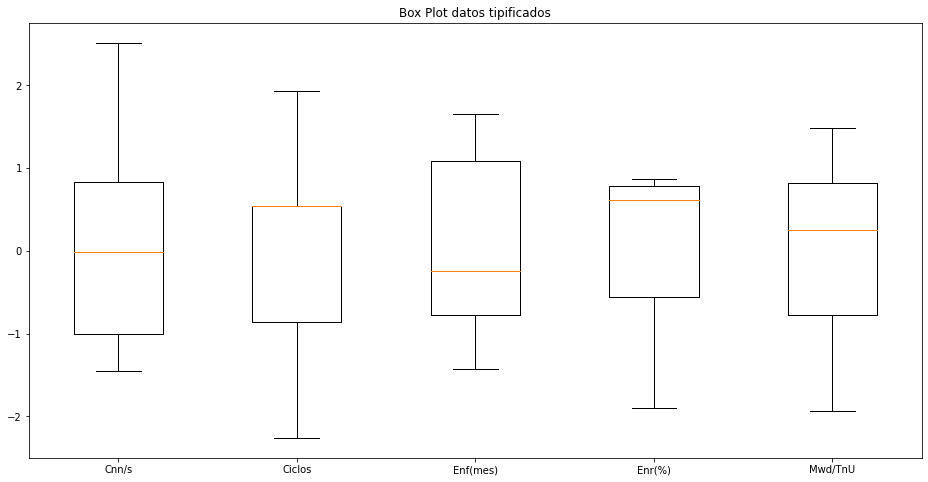

In [8]:
import matplotlib.pyplot as plt


fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Box Plot datos tipificados')
ax1.boxplot(data.values[:,5:10], labels=data.columns.tolist()[5:10])
plt.show()

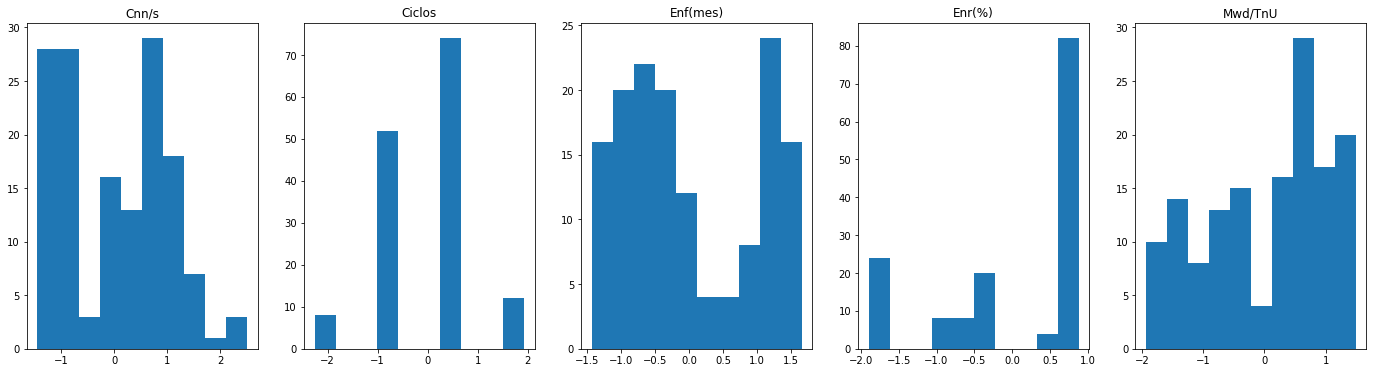

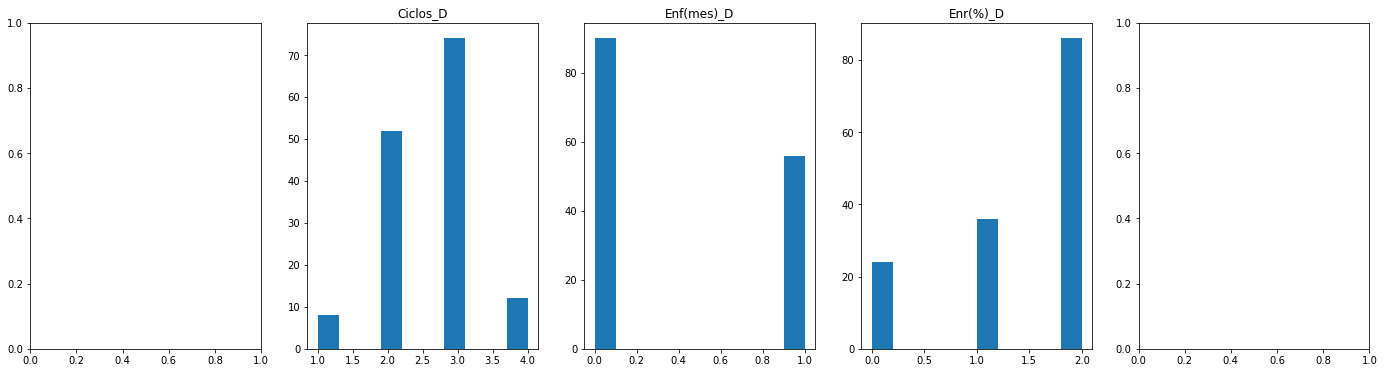

In [9]:
# Diagramas de las variables tipificadas
fig2,ax2 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax2[a].hist(data[var].values)
    ax2[a].set_title(var)
    a+1
plt.show()


# Diagramas de las variables discretizadas
fig3,ax3 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax3[a+1].hist(data[var].values)
    ax3[a+1].set_title(var)
    a+1
plt.show()
plt.close()

### Coeficiente de correlación entre Cnn/s y Mwd/TnU

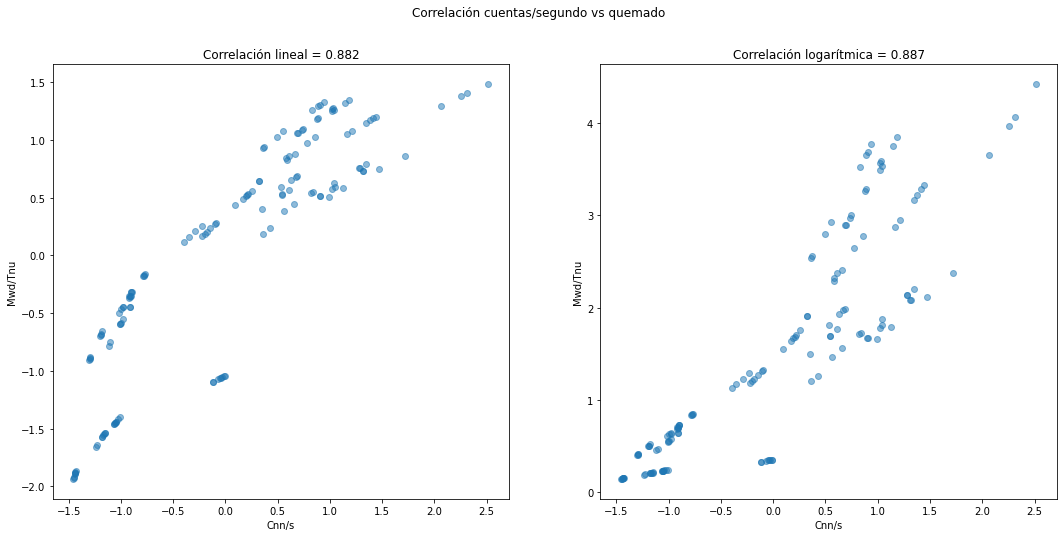

In [10]:
indep = data['Cnn/s'].values
dep = data['Mwd/TnU'].values
depLog = np.exp(data['Mwd/TnU'].values)

corrcoef = np.corrcoef(indep,dep)
corrcoefLog = np.corrcoef(indep,depLog)


fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')

ax[1].plot(indep, depLog, 'o', alpha=0.5)
ax[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefLog[0,1]))
ax[1].set_xlabel('Cnn/s')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Correlación cuentas/segundo vs quemado')

plt.show()
plt.close()

### Mínimos cuadrados:  $\beta = (X^{T}X)^{-1}X^{T}Y$

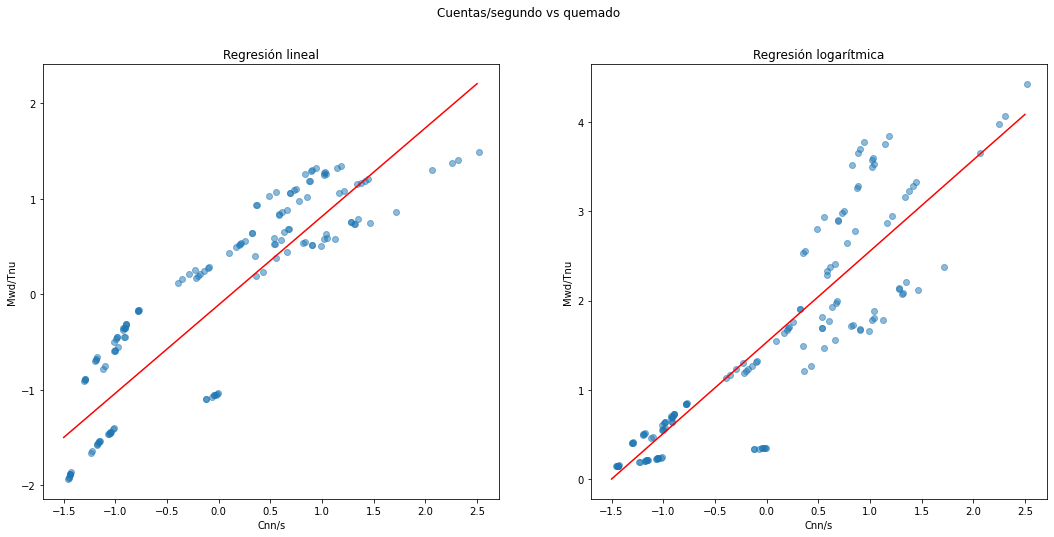

In [11]:
# Incluyo término independiente
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
BLog = np.linalg.inv(X.T @ X) @ X.T @ np.exp(data['Mwd/TnU'])
# print(B)
# print(BLog)


# Gráficas incluyendo la línea de regresión
fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')
ax[0].plot([-1.5, 2.5], [B[0]-1.5, B[0]+B[1]*2.5], c='red')

ax[1].plot(indep, depLog, 'o', alpha=0.5)
ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('Cnn/s')
ax[1].set_ylabel('Mwd/Tnu')
ax[1].plot([-1.5, 2.5], [BLog[0]-1.5, BLog[0]+BLog[1]*2.5], c='red')

fig.suptitle('Cuentas/segundo vs quemado')

plt.show()
plt.close()

### Correlación separando por colores según las demás variables

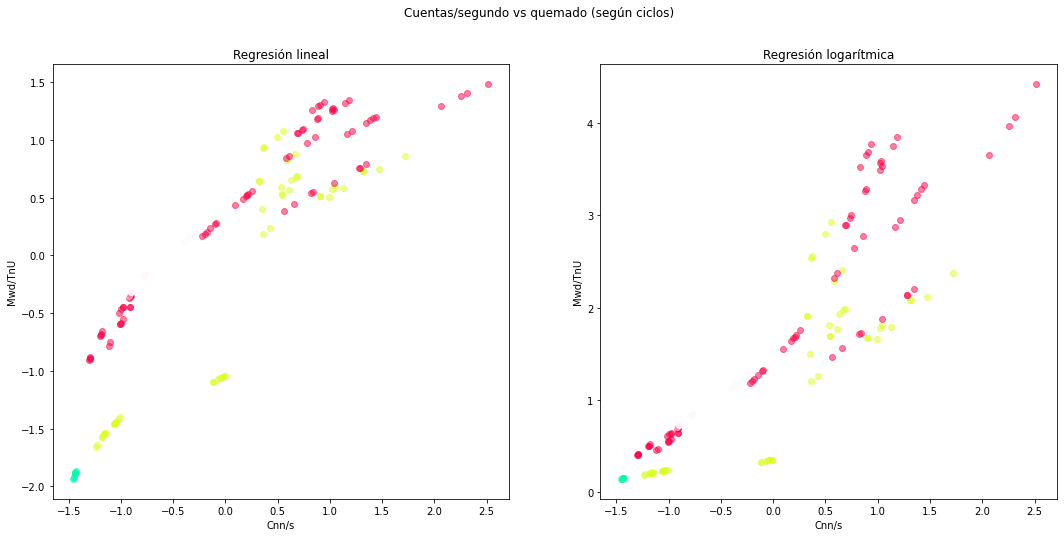

In [12]:
import matplotlib

cmap = matplotlib.cm.get_cmap('gist_ncar')

fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Ciclos_D'].values))

for i in range(colores+1):
    indep = data['Cnn/s'].loc[data['Ciclos_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Ciclos_D']==i].values
    depLog = np.exp(data['Mwd/TnU']).loc[data['Ciclos_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indep,depLog, 'o', alpha=0.5, c=cmap(i/colores))
    
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('Cnn/s')
ax[1].set_ylabel('Mwd/TnU')

fig.suptitle('Cuentas/segundo vs quemado (según ciclos)')

plt.show()
plt.close()

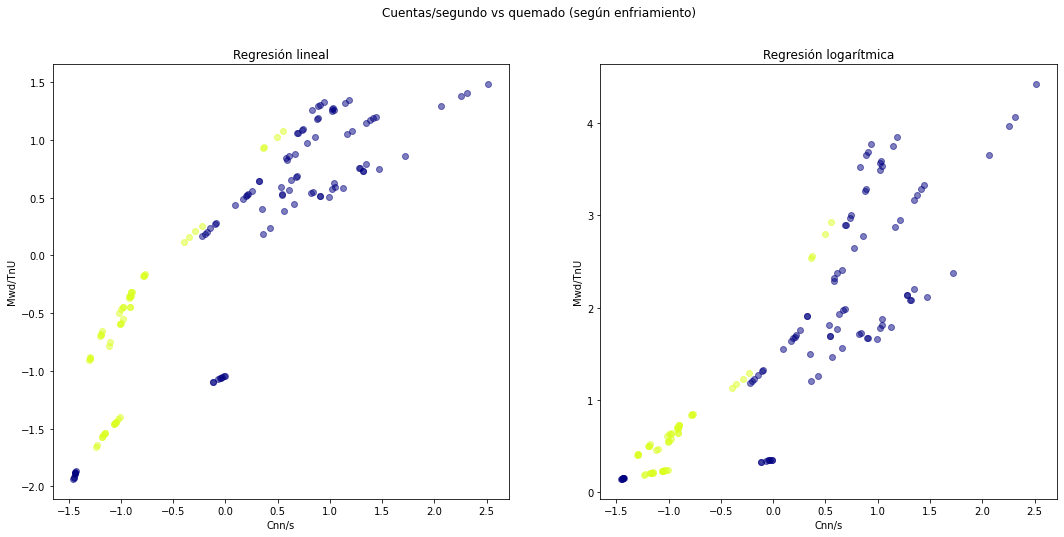

In [13]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enf(mes)_D'].values)+1)

for i in range(colores+1):
    indep = data['Cnn/s'].loc[data['Enf(mes)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enf(mes)_D']==i].values
    depLog = np.exp(data['Mwd/TnU']).loc[data['Enf(mes)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indep,depLog, 'o', alpha=0.5, c=cmap(i/colores))
    
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('Cnn/s')
ax[1].set_ylabel('Mwd/TnU')

fig.suptitle('Cuentas/segundo vs quemado (según enfriamiento)')

plt.show()
plt.close()

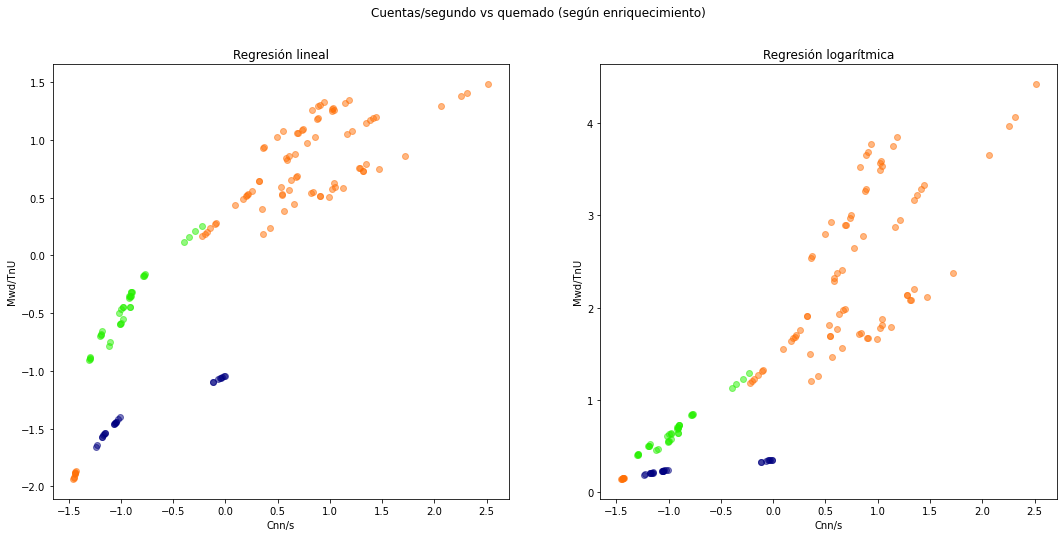

In [14]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enr(%)_D'].values)+1)

for i in range(colores+1):
    indep = data['Cnn/s'].loc[data['Enr(%)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enr(%)_D']==i].values
    depLog = np.exp(data['Mwd/TnU']).loc[data['Enr(%)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indep,depLog, 'o', alpha=0.5, c=cmap(i/colores))

ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('Cnn/s')
ax[1].set_ylabel('Mwd/TnU')

fig.suptitle('Cuentas/segundo vs quemado (según enriquecimiento)')

plt.show()
plt.close()

### Mínimos cuadrados con todas las variables: $\beta = (X^{T}X)^{-1}X^{T}Y$

In [15]:
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s'], data['Ciclos'], data['Enf(mes)'], data['Enr(%)']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
BLog = np.linalg.inv(X.T @ X) @ X.T @ np.exp(data['Mwd/TnU'])

print(B)
print()
print(BLog)

[4.345e-16 8.662e-01 1.011e-01 4.736e-01 5.258e-01]

[ 1.503  1.217 -0.187  0.809  0.632]


Entonces:

$Mwd/Tnu = B[0] + B[1] \cdot Cnn/s + B[2] \cdot Ciclos + B[3] \cdot Enf(mes) + B[4] \cdot Enr(\%)$

$Mwd/Tnu = BLog[0] + BLog[1] \cdot Cnn/s + BLog[2] \cdot Ciclos + BLog[3] \cdot Enf(mes) + BLog[4] \cdot Enr(\%)$

# Entrenamiento LOOCV (Leave One Out Cross Validation)

In [16]:
data.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU,Ciclos_D,Enf(mes)_D,Enr(%)_D
ind,,,,,,,,,,,,,
1,BL09,1,1.0,0.0,0.0,-0.103873,0.536875,-0.602062,0.871258,0.273655,3.0,0.0,2.0
2,BL09,2,1.0,0.0,0.0,0.218885,0.536875,-0.602062,0.871258,0.532389,3.0,0.0,2.0
3,BL09,3,1.0,0.0,0.0,0.258954,0.536875,-0.602062,0.871258,0.562256,3.0,0.0,2.0
4,BL09,4,1.0,0.0,0.0,-0.199524,0.536875,-0.602062,0.871258,0.189741,3.0,0.0,2.0
5,BL09,5,1.0,0.0,0.0,-0.144162,0.536875,-0.602062,0.871258,0.238809,3.0,0.0,2.0


In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Creo nuevos dataframes vacíos, donde iré guardando los resultados de cada iteración.
LOOCV = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])
LOOCVLOG = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])


# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)


# En cada bucle separo las 4 u 8 medidas de un elemento en "valid" y el resto de medidas las guardo en "entren"
# para hacer las regresiones con ellas, y voy almacenando los resultados en los nuevos dataframes.
agrupa = data.groupby(data.EECC)
for excluido in lista:
    # print(excluido)
    
    valid = agrupa.get_group(excluido)
    valid = np.mean(valid.values[:,5:10], axis=0)
    # print(valid)
    
    entren = data[data.EECC != excluido]
    # print(entren)
    
    X = np.array([np.ones(entren['Cnn/s'].shape[0]), entren['Cnn/s'], entren['Ciclos'], entren['Enf(mes)'], entren['Enr(%)']]).T
    B = np.linalg.inv(X.T @ X) @ X.T @ entren['Mwd/TnU']
    BLog = np.linalg.inv(X.T @ X) @ X.T @ np.exp(entren['Mwd/TnU'])

    sol = valid[4]
    calc = B[0]+B[1]*valid[0]+B[2]*valid[1]+B[3]*valid[2]+B[4]*valid[3]
    calcLog = BLog[0]+BLog[1]*valid[0]+BLog[2]*valid[1]+BLog[3]*valid[2]+BLog[4]*valid[3]
    calcLog = np.log(max(1e-7, calcLog)) # Cambio los resultados negativos por 0 para poder hacer el logaritmo
    error = ((calc - sol)/sol)*100
    errorLog = ((calcLog - sol)/sol)*100
    # print('{0:.2f} %'.format(error))
    # print('{0:.2f} %'.format(errorLog))

    LOOCV = LOOCV.append({'Excluido': excluido, 'Predicción': calc, 'Validación': sol, 'Error': '{0:.2f}%'.format(error)}, ignore_index = True)
    LOOCVLOG = LOOCVLOG.append({'Excluido': excluido, 'Predicción': calcLog, 'Validación': sol, 'Error': '{0:.2f}%'.format(errorLog)}, ignore_index = True)


print('REGRESIÓN LINEAL')
display(LOOCV)
print()
rmse = mean_squared_error(LOOCV.values[:,2], LOOCV.values[:,1], squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(LOOCV.values[:,2], LOOCV.values[:,1])
print('MAE =', '{0:.2f}'.format(mae))

print()
print()
print()

print('REGRESIÓN LOGARÍTMICA')
display(LOOCVLOG)
print()
rmse = mean_squared_error(LOOCVLOG.values[:,2], LOOCVLOG.values[:,1], squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(LOOCVLOG.values[:,2], LOOCVLOG.values[:,1])
print('MAE =', '{0:.2f}'.format(mae))

REGRESIÓN LINEAL


,Excluido,Predicción,Validación,Error
0,BL09,0.214449,0.371791,-42.32%
1,BT18,0.783182,0.676038,15.85%
2,BR03,0.890665,0.734825,21.21%
3,BP08,2.099059,1.391645,50.83%
4,BM09,1.317191,1.141534,15.39%
5,BK49,0.875361,0.925823,-5.45%
6,BJ12,1.327539,1.295909,2.44%
7,BH08,1.033677,1.154497,-10.47%
8,BS40,-1.181718,-1.898310,-37.75%
9,BS19,0.444042,0.511959,-13.27%



RMSE = 0.26

MAE = 0.19



REGRESIÓN LOGARÍTMICA


,Excluido,Predicción,Validación,Error
0,BL09,0.403813,0.371791,8.61%
1,BT18,0.977434,0.676038,44.58%
2,BR03,0.845600,0.734825,15.08%
3,BP08,1.331411,1.391645,-4.33%
4,BM09,1.070664,1.141534,-6.21%
5,BK49,0.879058,0.925823,-5.05%
6,BJ12,1.100117,1.295909,-15.11%
7,BH08,0.965717,1.154497,-16.35%
8,BS40,-16.118096,-1.898310,749.08%
9,BS19,0.816924,0.511959,59.57%



RMSE = 4.16

MAE = 1.40


# Regresión con Random Forest

In [18]:
data.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU,Ciclos_D,Enf(mes)_D,Enr(%)_D
ind,,,,,,,,,,,,,
1,BL09,1,1.0,0.0,0.0,-0.103873,0.536875,-0.602062,0.871258,0.273655,3.0,0.0,2.0
2,BL09,2,1.0,0.0,0.0,0.218885,0.536875,-0.602062,0.871258,0.532389,3.0,0.0,2.0
3,BL09,3,1.0,0.0,0.0,0.258954,0.536875,-0.602062,0.871258,0.562256,3.0,0.0,2.0
4,BL09,4,1.0,0.0,0.0,-0.199524,0.536875,-0.602062,0.871258,0.189741,3.0,0.0,2.0
5,BL09,5,1.0,0.0,0.0,-0.144162,0.536875,-0.602062,0.871258,0.238809,3.0,0.0,2.0


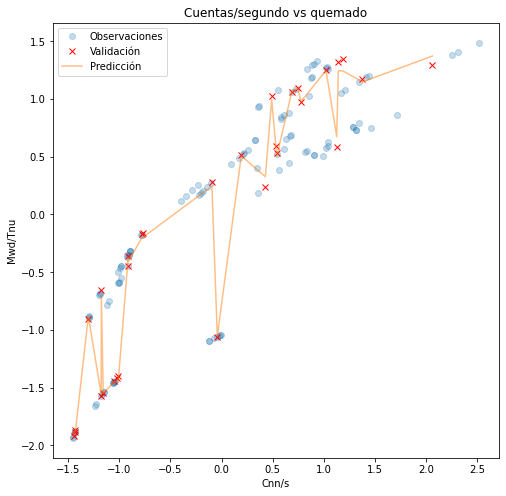

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
5,-1.447691,-1.914977,-1.909517,-0.29%
23,-1.437986,-1.887243,-1.879519,-0.41%
13,-1.429678,-1.864131,-1.875996,0.64%
9,-1.303516,-0.905760,-0.883156,-2.50%
21,-1.177648,-1.572092,-1.556689,-0.98%
1,-1.175957,-0.656982,-0.703822,7.13%
12,-1.158018,-1.545069,-1.548948,0.25%
28,-1.050089,-1.443614,-1.448007,0.30%
22,-1.024062,-1.413509,-1.447327,2.39%
14,-1.011049,-1.398694,-1.447327,3.48%


Precisión del entrenamiento = 99.92%
Precisión de la validación = 99.85%

RMSE = 0.04

MAE = 0.03


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# X almacena las variables independientes
# Y almacena la variable dependiente
X = data.iloc[:, 5:9].values
Y = data.iloc[:, 9].values
# print(X)
# print(Y)


# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))
'''
¿ESTÁ BIEN ELEGIR TOTALMENTE ALEATORIO LOS DATOS DE ENTRENAMIENTO Y VALIDACIÓN?
¿0 DEBERÍA SEPARAR AQUÍ TAMBIÉN TODAS LAS MEDIDAS DE UN MISMO ELEMENTO EN CONJUNTO?
'''


# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 2000, max_depth = 6)
bosque.fit(Xent, Yent)
'''
EN PRINCIPIO CUANTOS MÁS ÁRBOLES MEJOR, PERO NO HE VISTO DIFERENCIA SIGNITICATIVA EN UN RANGO DE ENTRE 200 A 50000.
TAMPOCO APRECIO DIFERENCIAS ENTRE PROFUNDIADES DE VALOR ENTRE 4 Y 10.
¿HAY ALGÚN MODO DE ELEGIR EL NÚMERO DE ESTIMADORES Y DE PROFUNDIDAD MÁS ÓPTIMOS?
'''

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')

fig,ax = plt.subplots(figsize=(8,8))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.5, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))




## ¿CÓMO ES POSIBLE QUE HABIENDO BASTANTES ERRORES RELATIVOS ALTOS, (A VECES DE MÁS DE UN 30%), SALGA UNA TASA DE ACIERTO DEL 99% Y UN RMSE Y MAE TAN BAJOS?

# ¿Cómo puedo asegurarme de que no hay sobre-entrenamiento?